In [2]:
import sys
import os

import sys, os
sys.path.append(os.path.abspath('workspace'))  # 👈 add this line

sys.path.append(os.path.abspath('.'))

from model_training.training import conv_neural_network,save_model
from model_training.model_eval import compute_avg_mae
from src.config import CONFIG
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv("workspace/data/train_data.csv")
val_df = pd.read_csv("workspace/data/val_data.csv")
test_df = pd.read_csv("workspace/data/test_data.csv")

l2_penalty = CONFIG["l2_penalty"]
conv1_filters = CONFIG["conv1_filters"]
conv2_filters = CONFIG["conv2_filters"]
conv3_filters = CONFIG["conv3_filters"]
dense1_units = CONFIG["dense1_units"]
dense2_units = CONFIG["dense2_units"]
dropout_rate = CONFIG["dropout_rate"]
learning_rate = CONFIG["learning_rate"]
earlystop_patience = CONFIG["earlystop_patience"]
training_epochs = CONFIG["training_epochs"]

2025-10-16 11:20:16.814966: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-16 11:20:16.815033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-16 11:20:16.816605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-16 11:20:16.825494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 11:20:24.370250: I tensorflow/core/common_

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, Model, Input, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization


import pandas as pd



# --- defining training data mean and standard deviation for target normalisation ---
target_train_raw = train_df[['dot_XCam', 'dot_YCam']].values.astype('float32')
target_mean = target_train_raw.mean(axis=0)
target_std = target_train_raw.std(axis=0)

# Convert to tf constants once so they can be used in metrics
target_mean_tf = tf.constant(target_mean, dtype=tf.float32)
target_std_tf = tf.constant(target_std, dtype=tf.float32)

# --- Helper functions
def load_npz_tf(face_path, l_eye_path, r_eye_path, label):
    def _load(path_tensor):
        path_str = path_tensor.numpy().decode("utf-8")
        arr = np.load(path_str)['image']
        return arr.astype(np.float32)

    face = tf.py_function(_load, [face_path], tf.float32)
    l_eye = tf.py_function(_load, [l_eye_path], tf.float32)
    r_eye = tf.py_function(_load, [r_eye_path], tf.float32)

    face.set_shape([64, 64, 3])
    l_eye.set_shape([64, 64, 3])
    r_eye.set_shape([64, 64, 3])
    
    # normalize labels
    label = (label - tf.constant(target_mean, tf.float32)) / tf.constant(target_std, tf.float32)

    return (face, l_eye, r_eye), label


def create_dataset(df, batch_size=64):
    face_paths = df['face_crop_path'].values
    l_eye_paths = df['l_eye_crop_path'].values
    r_eye_paths = df['r_eye_crop_path'].values
    labels = df[['dot_XCam', 'dot_YCam']].values.astype('float32')

    ds = tf.data.Dataset.from_tensor_slices((face_paths, l_eye_paths, r_eye_paths, labels))
    ds = ds.map(load_npz_tf, num_parallel_calls=tf.data.AUTOTUNE)

    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# --- loading train and validation from csv ---
train_ds = create_dataset(train_df, batch_size=64)
val_ds = create_dataset(val_df, batch_size=64)


# --- custom metric for denormalized MAE ---
def denorm_mae(y_true, y_pred):
    y_true_denorm = y_true * target_std_tf + target_mean_tf
    y_pred_denorm = y_pred * target_std_tf + target_mean_tf
    return tf.reduce_mean(tf.abs(y_true_denorm - y_pred_denorm))

# --- model ---

def arch_1_conv_neural_network( conv1_filters, 
                        conv2_filters, 
                        conv3_filters, 
                        dense1_units,
                        dense2_units,
                        learning_rate,
                        training_epochs):
    
    
    
    face_input = Input(shape=(64, 64, 3), name="face_input")
    x_face = layers.Conv2D(conv1_filters, 3, activation='relu')(face_input)
    x_face = layers.MaxPooling2D()(x_face)
    x_face = layers.Conv2D(conv2_filters, 3, activation='relu')(x_face)
    x_face = layers.MaxPooling2D()(x_face)
    x_face = layers.Conv2D(conv3_filters, 3, activation='relu')(x_face)
    x_face = layers.Flatten()(x_face)
    x_face = layers.Dense(dense1_units, activation='relu')(x_face)
    
    l_eye_input = Input(shape=(64, 64, 3), name="left_eye_input")
    x_left = layers.Conv2D(conv1_filters, 3, activation='relu')(l_eye_input)
    x_left = layers.MaxPooling2D()(x_left)
    x_left = layers.Conv2D(conv2_filters, 3, activation='relu')(x_left)
    x_left = layers.MaxPooling2D()(x_left)
    x_left = layers.Conv2D(conv3_filters, 3, activation='relu')(x_left)
    x_left = layers.Flatten()(x_left)
    x_left = layers.Dense(dense1_units, activation='relu')(x_left)

    r_eye_input = Input(shape=(64, 64, 3), name="right_eye_input")
    x_right = layers.Conv2D(conv1_filters, 3, activation='relu')(r_eye_input)
    x_right = layers.MaxPooling2D()(x_right)
    x_right = layers.Conv2D(conv2_filters, 3, activation='relu')(x_right)
    x_right = layers.MaxPooling2D()(x_right)
    x_right = layers.Conv2D(conv3_filters, 3, activation='relu')(x_right)
    x_right = layers.Flatten()(x_right)
    x_right = layers.Dense(dense1_units, activation='relu')(x_right)
    
    combined = layers.Concatenate()([x_face, x_left, x_right])
    x = layers.Dense(dense2_units, activation='relu')(combined)
    output = layers.Dense(2)(x)
    
    model = Model(inputs=[face_input, l_eye_input, r_eye_input], outputs=output)
    
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse',                   # still in normalized space
    metrics=[denorm_mae]          # MAE in de-normalized space
)
    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=training_epochs
)
    
    return model, history

def arch_2_conv_neural_network(l2_penalty, 
                        conv1_filters, 
                        conv2_filters, 
                        conv3_filters, 
                        dense1_units,
                        dense2_units,
                        learning_rate,
                        training_epochs):
    
    reg = regularizers.l2(l2_penalty)
    
    face_input = Input(shape=(64, 64, 3), name="face_input")
    x_face = layers.Conv2D(conv1_filters, 3, activation='relu', kernel_regularizer=reg)(face_input)
    x_face = layers.MaxPooling2D()(x_face)
    x_face = layers.Conv2D(conv2_filters, 3, activation='relu', kernel_regularizer=reg)(x_face)
    x_face = layers.MaxPooling2D()(x_face)
    x_face = layers.Conv2D(conv3_filters, 3, activation='relu', kernel_regularizer=reg)(x_face)
    x_face = layers.Flatten()(x_face)
    x_face = layers.Dense(dense1_units, activation='relu', kernel_regularizer=reg)(x_face)
    
    l_eye_input = Input(shape=(64, 64, 3), name="left_eye_input")
    x_left = layers.Conv2D(conv1_filters, 3, activation='relu', kernel_regularizer=reg)(l_eye_input)
    x_left = layers.MaxPooling2D()(x_left)
    x_left = layers.Conv2D(conv2_filters, 3, activation='relu', kernel_regularizer=reg)(x_left)
    x_left = layers.MaxPooling2D()(x_left)
    x_left = layers.Conv2D(conv3_filters, 3, activation='relu', kernel_regularizer=reg)(x_left)
    x_left = layers.Flatten()(x_left)
    x_left = layers.Dense(dense1_units, activation='relu', kernel_regularizer=reg)(x_left)

    r_eye_input = Input(shape=(64, 64, 3), name="right_eye_input")
    x_right = layers.Conv2D(conv1_filters, 3, activation='relu', kernel_regularizer=reg)(r_eye_input)
    x_right = layers.MaxPooling2D()(x_right)
    x_right = layers.Conv2D(conv2_filters, 3, activation='relu', kernel_regularizer=reg)(x_right)
    x_right = layers.MaxPooling2D()(x_right)
    x_right = layers.Conv2D(conv3_filters, 3, activation='relu', kernel_regularizer=reg)(x_right)
    x_right = layers.Flatten()(x_right)
    x_right = layers.Dense(dense1_units, activation='relu', kernel_regularizer=reg)(x_right)
    
    combined = layers.Concatenate()([x_face, x_left, x_right])
    x = layers.Dense(dense2_units, activation='relu', kernel_regularizer=reg)(combined)
    output = layers.Dense(2, kernel_regularizer=reg)(x)
    
    model = Model(inputs=[face_input, l_eye_input, r_eye_input], outputs=output)
    
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse',                   # still in normalized space
    metrics=[denorm_mae]          # MAE in de-normalized space
)

    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=training_epochs
)
    
    return model, history

def arch_3_conv_neural_network(l2_penalty, 
                        conv1_filters, 
                        conv2_filters, 
                        conv3_filters, 
                        dense1_units,
                        dense2_units,
                        dropout_rate,
                        learning_rate,
                        training_epochs):
    
    reg = regularizers.l2(l2_penalty)
    
    face_input = Input(shape=(64, 64, 3), name="face_input")
    x_face = layers.Conv2D(conv1_filters, 3, activation='relu', kernel_regularizer=reg)(face_input)
    x_face = layers.MaxPooling2D()(x_face)
    x_face = layers.Conv2D(conv2_filters, 3, activation='relu', kernel_regularizer=reg)(x_face)
    x_face = layers.MaxPooling2D()(x_face)
    x_face = layers.Conv2D(conv3_filters, 3, activation='relu', kernel_regularizer=reg)(x_face)
    x_face = layers.Flatten()(x_face)
    x_face = layers.Dense(dense1_units, activation='relu', kernel_regularizer=reg)(x_face)
    x_face = layers.Dropout(dropout_rate)(x_face)
    
    l_eye_input = Input(shape=(64, 64, 3), name="left_eye_input")
    x_left = layers.Conv2D(conv1_filters, 3, activation='relu', kernel_regularizer=reg)(l_eye_input)
    x_left = layers.MaxPooling2D()(x_left)
    x_left = layers.Conv2D(conv2_filters, 3, activation='relu', kernel_regularizer=reg)(x_left)
    x_left = layers.MaxPooling2D()(x_left)
    x_left = layers.Conv2D(conv3_filters, 3, activation='relu', kernel_regularizer=reg)(x_left)
    x_left = layers.Flatten()(x_left)
    x_left = layers.Dense(dense1_units, activation='relu', kernel_regularizer=reg)(x_left)
    x_left = layers.Dropout(dropout_rate)(x_left)
    
    r_eye_input = Input(shape=(64, 64, 3), name="right_eye_input")
    x_right = layers.Conv2D(conv1_filters, 3, activation='relu', kernel_regularizer=reg)(r_eye_input)
    x_right = layers.MaxPooling2D()(x_right)
    x_right = layers.Conv2D(conv2_filters, 3, activation='relu', kernel_regularizer=reg)(x_right)
    x_right = layers.MaxPooling2D()(x_right)
    x_right = layers.Conv2D(conv3_filters, 3, activation='relu', kernel_regularizer=reg)(x_right)
    x_right = layers.Flatten()(x_right)
    x_right = layers.Dense(dense1_units, activation='relu', kernel_regularizer=reg)(x_right)
    x_right = layers.Dropout(dropout_rate)(x_right)

    combined = layers.Concatenate()([x_face, x_left, x_right])
    x = layers.Dense(dense2_units, activation='relu', kernel_regularizer=reg)(combined)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(2, kernel_regularizer=reg)(x)
    
    model = Model(inputs=[face_input, l_eye_input, r_eye_input], outputs=output)
    
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse',                   # still in normalized space
    metrics=[denorm_mae]          # MAE in de-normalized space
)

    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=training_epochs
)
    
    return model, history

def arch_4_conv_neural_network(l2_penalty, 
                        conv1_filters, 
                        conv2_filters, 
                        conv3_filters, 
                        dense1_units,
                        dense2_units,
                        dropout_rate,
                        learning_rate,
                        earlystop_patience,
                        training_epochs):
    
    reg = regularizers.l2(l2_penalty)
    
    face_input = Input(shape=(64, 64, 3), name="face_input")
    x_face = layers.Conv2D(conv1_filters, 3, activation='relu', kernel_regularizer=reg)(face_input)
    x_face = layers.MaxPooling2D()(x_face)
    x_face = layers.Conv2D(conv2_filters, 3, activation='relu', kernel_regularizer=reg)(x_face)
    x_face = layers.MaxPooling2D()(x_face)
    x_face = layers.Conv2D(conv3_filters, 3, activation='relu', kernel_regularizer=reg)(x_face)
    x_face = layers.Flatten()(x_face)
    x_face = layers.Dense(dense1_units, activation='relu', kernel_regularizer=reg)(x_face)
    x_face = layers.Dropout(dropout_rate)(x_face)
    
    l_eye_input = Input(shape=(64, 64, 3), name="left_eye_input")
    x_left = layers.Conv2D(conv1_filters, 3, activation='relu', kernel_regularizer=reg)(l_eye_input)
    x_left = layers.MaxPooling2D()(x_left)
    x_left = layers.Conv2D(conv2_filters, 3, activation='relu', kernel_regularizer=reg)(x_left)
    x_left = layers.MaxPooling2D()(x_left)
    x_left = layers.Conv2D(conv3_filters, 3, activation='relu', kernel_regularizer=reg)(x_left)
    x_left = layers.Flatten()(x_left)
    x_left = layers.Dense(dense1_units, activation='relu', kernel_regularizer=reg)(x_left)
    x_left = layers.Dropout(dropout_rate)(x_left)
    
    r_eye_input = Input(shape=(64, 64, 3), name="right_eye_input")
    x_right = layers.Conv2D(conv1_filters, 3, activation='relu', kernel_regularizer=reg)(r_eye_input)
    x_right = layers.MaxPooling2D()(x_right)
    x_right = layers.Conv2D(conv2_filters, 3, activation='relu', kernel_regularizer=reg)(x_right)
    x_right = layers.MaxPooling2D()(x_right)
    x_right = layers.Conv2D(conv3_filters, 3, activation='relu', kernel_regularizer=reg)(x_right)
    x_right = layers.Flatten()(x_right)
    x_right = layers.Dense(dense1_units, activation='relu', kernel_regularizer=reg)(x_right)
    x_right = layers.Dropout(dropout_rate)(x_right)

    combined = layers.Concatenate()([x_face, x_left, x_right])
    x = layers.Dense(dense2_units, activation='relu', kernel_regularizer=reg)(combined)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(2, kernel_regularizer=reg)(x)
    
    model = Model(inputs=[face_input, l_eye_input, r_eye_input], outputs=output)
    
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse',                   # still in normalized space
    metrics=[denorm_mae]          # MAE in de-normalized space
)

    early_stop = EarlyStopping(
    monitor='val_loss', patience=earlystop_patience, restore_best_weights=True, verbose=1
)

    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=training_epochs,
    callbacks=[early_stop]
)
    
    return model, history

def arch_5_conv_neural_network(l2_penalty, 
                        conv1_filters, 
                        conv2_filters, 
                        conv3_filters, 
                        dense1_units,
                        dense2_units,
                        dropout_rate,
                        learning_rate,
                        earlystop_patience,
                        training_epochs):
    
    reg = regularizers.l2(l2_penalty)
    
    face_input = Input(shape=(64, 64, 3), name="face_input")
    x_face = layers.Conv2D(conv1_filters, 3, activation='relu', kernel_regularizer=reg)(face_input)
    x_face = BatchNormalization()(x_face)
    x_face = layers.MaxPooling2D()(x_face)
    x_face = layers.Conv2D(conv2_filters, 3, activation='relu', kernel_regularizer=reg)(x_face)
    x_face = BatchNormalization()(x_face)
    x_face = layers.MaxPooling2D()(x_face)
    x_face = layers.Conv2D(conv3_filters, 3, activation='relu', kernel_regularizer=reg)(x_face)
    x_face = BatchNormalization()(x_face)
    x_face = layers.Flatten()(x_face)
    x_face = layers.Dense(dense1_units, activation='relu', kernel_regularizer=reg)(x_face)
    x_face = layers.Dropout(dropout_rate)(x_face)
    
    l_eye_input = Input(shape=(64, 64, 3), name="left_eye_input")
    x_left = layers.Conv2D(conv1_filters, 3, activation='relu', kernel_regularizer=reg)(l_eye_input)
    x_left = BatchNormalization()(x_left)
    x_left = layers.MaxPooling2D()(x_left)
    x_left = layers.Conv2D(conv2_filters, 3, activation='relu', kernel_regularizer=reg)(x_left)
    x_left = BatchNormalization()(x_left)
    x_left = layers.MaxPooling2D()(x_left)
    x_left = layers.Conv2D(conv3_filters, 3, activation='relu', kernel_regularizer=reg)(x_left)
    x_left = BatchNormalization()(x_left)
    x_left = layers.Flatten()(x_left)
    x_left = layers.Dense(dense1_units, activation='relu', kernel_regularizer=reg)(x_left)
    x_left = layers.Dropout(dropout_rate)(x_left)
    
    r_eye_input = Input(shape=(64, 64, 3), name="right_eye_input")
    x_right = layers.Conv2D(conv1_filters, 3, activation='relu', kernel_regularizer=reg)(r_eye_input)
    x_right = BatchNormalization()(x_right)
    x_right = layers.MaxPooling2D()(x_right)
    x_right = layers.Conv2D(conv2_filters, 3, activation='relu', kernel_regularizer=reg)(x_right)
    x_right = BatchNormalization()(x_right)
    x_right = layers.MaxPooling2D()(x_right)
    x_right = layers.Conv2D(conv3_filters, 3, activation='relu', kernel_regularizer=reg)(x_right)
    x_right = BatchNormalization()(x_right)
    x_right = layers.Flatten()(x_right)
    x_right = layers.Dense(dense1_units, activation='relu', kernel_regularizer=reg)(x_right)
    x_right = layers.Dropout(dropout_rate)(x_right)

    combined = layers.Concatenate()([x_face, x_left, x_right])
    x = layers.Dense(dense2_units, activation='relu', kernel_regularizer=reg)(combined)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(2, kernel_regularizer=reg)(x)
    
    model = Model(inputs=[face_input, l_eye_input, r_eye_input], outputs=output)
    
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse',                   # still in normalized space
    metrics=[denorm_mae]          # MAE in de-normalized space
)

    early_stop = EarlyStopping(
    monitor='val_loss', patience=earlystop_patience, restore_best_weights=True, verbose=1
)

    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=training_epochs,
    callbacks=[early_stop]
)
    
    return model, history

def save_model(model, model_name):

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    tflite_path = f"workspace/models/{model_name}.tflite"
    with open(tflite_path, "wb") as f:
        f.write(tflite_model)

    print(f"Model saved to: {tflite_path}")
    return tflite_path






## 🧠 Model 1: Simple CNN

### ⚙️ Hyperparameters

```python
SIMPLE_CONFIG = {   
    "conv1_filters": 32,
    "conv2_filters": 64,
    "conv3_filters": 128,
    "dense1_units": 128,
    "dense2_units": 128,  
    "learning_rate": 1e-3,
    "training_epochs": 25
}


Epoch 1/25
7430/7430 [==============================] - 2913s 391ms/step - loss: 0.5892 - denorm_mae: 1.6642 - val_loss: 0.4161 - val_denorm_mae: 1.3854
Epoch 2/25
7430/7430 [==============================] - 2890s 389ms/step - loss: 0.3601 - denorm_mae: 1.2784 - val_loss: 0.3471 - val_denorm_mae: 1.2414
Epoch 3/25
7430/7430 [==============================] - 2875s 387ms/step - loss: 0.2809 - denorm_mae: 1.1241 - val_loss: 0.3158 - val_denorm_mae: 1.1804
Epoch 4/25
7430/7430 [==============================] - 3148s 424ms/step - loss: 0.2280 - denorm_mae: 1.0179 - val_loss: 0.3110 - val_denorm_mae: 1.1619
Epoch 5/25
7430/7430 [==============================] - 3335s 449ms/step - loss: 0.1895 - denorm_mae: 0.9352 - val_loss: 0.3094 - val_denorm_mae: 1.1594
Epoch 6/25
7430/7430 [==============================] - 3205s 431ms/step - loss: 0.1618 - denorm_mae: 0.8696 - val_loss: 0.3203 - val_denorm_mae: 1.1897
Epoch 7/25
7430/7430 [==============================] - 3078s 414ms/step - loss: 0

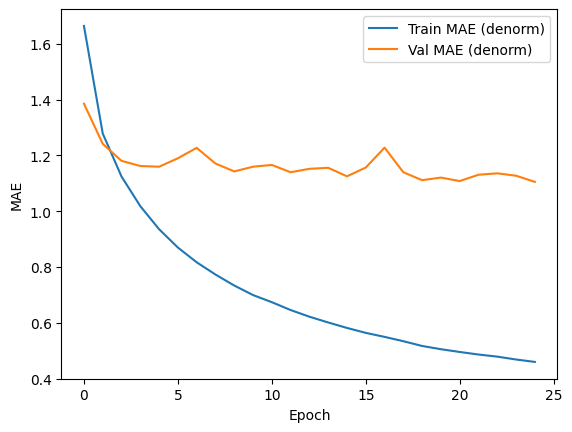

Train mae: 0.5873405344778948
Val mae: 1.1048333339691163


In [9]:
model_1, history_1 = arch_1_conv_neural_network(conv1_filters,
                                     conv2_filters,
                                     conv3_filters,
                                     dense1_units,
                                     dense2_units,
                                     learning_rate,
                                     training_epochs)

plt.plot(history_1.history['denorm_mae'], label='Train MAE (denorm)')
plt.plot(history_1.history['val_denorm_mae'], label='Val MAE (denorm)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

train_ds = create_dataset(train_df, batch_size=64)
val_ds = create_dataset(val_df, batch_size=64)

train_mae = compute_avg_mae(train_ds, model_1)
val_mae = compute_avg_mae(val_ds, model_1)

print(f"Train mae: {train_mae}")
print(f"Val mae: {val_mae}")



In [12]:
save_model(model_1, "model_1")

INFO:tensorflow:Assets written to: /tmp/tmpg6zbhwlu/assets


INFO:tensorflow:Assets written to: /tmp/tmpg6zbhwlu/assets
2025-10-14 08:50:24.174224: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-10-14 08:50:24.174296: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-10-14 08:50:24.174514: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpg6zbhwlu
2025-10-14 08:50:24.176906: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-10-14 08:50:24.176929: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpg6zbhwlu
2025-10-14 08:50:24.185469: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-10-14 08:50:24.388264: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpg6zbhwlu
2025-10-14 08:50:24.414102: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Model saved to: workspace/models/model_1.tflite


'workspace/models/model_1.tflite'

## 🧠 Model 2: CNN with L2 regularization

### ⚙️ Hyperparameters

```python
CONFIG = {"l2_penalty":1e-5,
          "conv1_filters":32,
          "conv2_filters":64,
          "conv3_filters":128,
          "dense1_units":128,
          "dense2_units":128,
          "learning_rate":1e-3,
          "training_epochs":25}

Epoch 1/25
7430/7430 [==============================] - 3158s 424ms/step - loss: 0.6754 - denorm_mae: 1.7821 - val_loss: 0.5217 - val_denorm_mae: 1.5679
Epoch 2/25
7430/7430 [==============================] - 3151s 424ms/step - loss: 0.4805 - denorm_mae: 1.4695 - val_loss: 0.4649 - val_denorm_mae: 1.4421
Epoch 3/25
7430/7430 [==============================] - 3317s 446ms/step - loss: 0.4359 - denorm_mae: 1.3781 - val_loss: 0.4472 - val_denorm_mae: 1.3880
Epoch 4/25
7430/7430 [==============================] - 3347s 450ms/step - loss: 0.4125 - denorm_mae: 1.3268 - val_loss: 0.4390 - val_denorm_mae: 1.3447
Epoch 5/25
7430/7430 [==============================] - 3144s 423ms/step - loss: 0.3984 - denorm_mae: 1.2931 - val_loss: 0.4550 - val_denorm_mae: 1.3953
Epoch 6/25
7430/7430 [==============================] - 2957s 398ms/step - loss: 0.3876 - denorm_mae: 1.2677 - val_loss: 0.4454 - val_denorm_mae: 1.3414
Epoch 7/25
7430/7430 [==============================] - 3040s 409ms/step - loss: 0

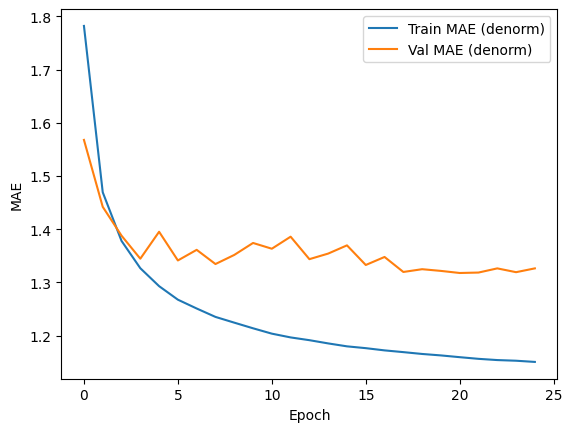

In [5]:
model_2, history_2 = arch_2_conv_neural_network(
                                    l2_penalty, 
                                    conv1_filters,
                                    conv2_filters,
                                    conv3_filters,
                                    dense1_units,
                                    dense2_units,
                                    learning_rate,
                                    training_epochs)

plt.plot(history_2.history['denorm_mae'], label='Train MAE (denorm)')
plt.plot(history_2.history['val_denorm_mae'], label='Val MAE (denorm)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [6]:
train_ds = create_dataset(train_df, batch_size=64)
val_ds = create_dataset(val_df, batch_size=64)

train_mae = compute_avg_mae(train_ds, model_2)
val_mae = compute_avg_mae(val_ds, model_2)

print(f"Train mae: {train_mae}")
print(f"Val mae: {val_mae}")

Train mae: 1.1770353574153214
Val mae: 1.3264664785385132


In [8]:
save_model(model_2, "model_2")

INFO:tensorflow:Assets written to: /tmp/tmpi5o7re70/assets


INFO:tensorflow:Assets written to: /tmp/tmpi5o7re70/assets
2025-10-17 10:27:36.531014: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-10-17 10:27:36.531069: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-10-17 10:27:36.531257: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpi5o7re70
2025-10-17 10:27:36.533563: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-10-17 10:27:36.533581: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpi5o7re70
2025-10-17 10:27:36.541707: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-10-17 10:27:36.735180: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpi5o7re70
2025-10-17 10:27:36.761575: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Model saved to: workspace/models/model_2.tflite


'workspace/models/model_2.tflite'

We saw that after adding L2 regularization, the training MAE increased significantly while the validation MAE also rose slightly.
This happened because the L2 penalty was too strong, causing the model’s weights to be overly constrained and preventing it from learning complex patterns — a case of underfitting.
Therefore, we decided to reduce the L2 penalty by a factor of 10 to relax the regularization strength, allowing the model to learn more effectively while still controlling overfitting.

## 🧠 Model 3: Reduced L2

### ⚙️ Hyperparameters

```python
CONFIG = {"l2_penalty":1e-6,
          "conv1_filters":32,
          "conv2_filters":64,
          "conv3_filters":128,
          "dense1_units":128,
          "dense2_units":128,
          "learning_rate":1e-3,
          "training_epochs":25}

In [ ]:
model_3, history_3 = arch_2_conv_neural_network(
                                    l2_penalty, 
                                    conv1_filters,
                                    conv2_filters,
                                    conv3_filters,
                                    dense1_units,
                                    dense2_units,
                                    learning_rate,
                                    training_epochs)

plt.plot(history_3.history['denorm_mae'], label='Train MAE (denorm)')
plt.plot(history_3.history['val_denorm_mae'], label='Val MAE (denorm)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

Epoch 1/25
7430/7430 [==============================] - 3534s 475ms/step - loss: 0.6743 - denorm_mae: 1.7777 - val_loss: 0.5260 - val_denorm_mae: 1.5696
Epoch 2/25
7430/7430 [==============================] - 3388s 456ms/step - loss: 0.4787 - denorm_mae: 1.4673 - val_loss: 0.4558 - val_denorm_mae: 1.4293
Epoch 3/25
7430/7430 [==============================] - 3378s 455ms/step - loss: 0.4313 - denorm_mae: 1.3710 - val_loss: 0.4475 - val_denorm_mae: 1.4137
Epoch 4/25
7430/7430 [==============================] - 3382s 455ms/step - loss: 0.4073 - denorm_mae: 1.3188 - val_loss: 0.4443 - val_denorm_mae: 1.4026
Epoch 5/25
7430/7430 [==============================] - 3121s 420ms/step - loss: 0.3919 - denorm_mae: 1.2842 - val_loss: 0.4359 - val_denorm_mae: 1.3716
Epoch 6/25
7430/7430 [==============================] - 3310s 445ms/step - loss: 0.3817 - denorm_mae: 1.2599 - val_loss: 0.4332 - val_denorm_mae: 1.3485
Epoch 7/25
7430/7430 [==============================] - 2614s 352ms/step - loss: 0

In [ ]:
train_ds = create_dataset(train_df, batch_size=64)
val_ds = create_dataset(val_df, batch_size=64)

train_mae = compute_avg_mae(train_ds, model_3)
val_mae = compute_avg_mae(val_ds, model_3)

print(f"Train mae: {train_mae}")
print(f"Val mae: {val_mae}")

In [ ]:
save_model(model_3, "model_3")

## 🧠 Model 4: Dropout added

### ⚙️ Hyperparameters

```python
CONFIG = {"l2_penalty":1e-6,
          "conv1_filters":32,
          "conv2_filters":64,
          "conv3_filters":128,
          "dense1_units":128,
          "dense2_units":128,
          "dropout_rate":0.3,
          "learning_rate":1e-3,
          "training_epochs":25}

In [ ]:
model_4, history_4 = arch_3_conv_neural_network(
                                    l2_penalty, 
                                    conv1_filters,
                                    conv2_filters,
                                    conv3_filters,
                                    dense1_units,
                                    dense2_units,
                                    dropout_rate,
                                    learning_rate,
                                    training_epochs)

plt.plot(history_4.history['denorm_mae'], label='Train MAE (denorm)')
plt.plot(history_4.history['val_denorm_mae'], label='Val MAE (denorm)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
save_model(model_4, "model_4")

## 🧠 Model 5: Earlystopping added

### ⚙️ Hyperparameters

```python
CONFIG = {"l2_penalty":1e-6,
          "conv1_filters":32,
          "conv2_filters":64,
          "conv3_filters":128,
          "dense1_units":128,
          "dense2_units":128,
          "dropout_rate":0.3,
          "learning_rate":1e-3,
          "earlystop_patience":8,
          "training_epochs":25}

In [ ]:
model_5, history_5 = arch_4_conv_neural_network(
                                    l2_penalty, 
                                    conv1_filters,
                                    conv2_filters,
                                    conv3_filters,
                                    dense1_units,
                                    dense2_units,
                                    dropout_rate,
                                    learning_rate,
                                    earlystop_patience,
                                    training_epochs)

plt.plot(history_5.history['denorm_mae'], label='Train MAE (denorm)')
plt.plot(history_5.history['val_denorm_mae'], label='Val MAE (denorm)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
save_model(model_5, "model_5")

## 🧠 Model G: Batch Normalisation added

### ⚙️ Hyperparameters

```python
CONFIG = {"l2_penalty":1e-6,
          "conv1_filters":32,
          "conv2_filters":64,
          "conv3_filters":128,
          "dense1_units":128,
          "dense2_units":128,
          "dropout_rate":0.3,
          "learning_rate":1e-3,
          "earlystop_patience":8,
          "training_epochs":25}

In [ ]:
model_6, history_6 = arch_5_conv_neural_network(
                                    l2_penalty, 
                                    conv1_filters,
                                    conv2_filters,
                                    conv3_filters,
                                    dense1_units,
                                    dense2_units,
                                    dropout_rate,
                                    learning_rate,
                                    earlystop_patience,
                                    training_epochs)

plt.plot(history_6.history['denorm_mae'], label='Train MAE (denorm)')
plt.plot(history_6.history['val_denorm_mae'], label='Val MAE (denorm)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
save_model(model_6, "model_6")